## Association subtypes emotional task

In [1]:
import seaborn as sns
import os
import json
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
import scipy.io #read .mat files
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVR
from sklearn import preprocessing, linear_model
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

In [3]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [6]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

## Random forest and linear regressionn association 

In [7]:
def RandomForest_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=1000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp = np.zeros((skf.n_splits,X.shape[1]))
    scores = np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        feimp[c,:] = rfr.feature_importances_[:]
        
        std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        #     plt.figure()
        #     plt.scatter(y_test, y_test, edgecolor='k',
        #             c="navy", s=s, marker="s", alpha=a, label="Test Data")
        
        #     plt.scatter(y_train, pred, edgecolor='k',
        #             c="c", s=s, marker="^", alpha=a,
        #             label="Prediction -- RF score=%.2f" % rsq)
        #     plt.title("Prediction on subset number {}".format(c))
        #     plt.legend()
        #     plt.show()
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,feimp, scores,std

In [8]:
def SVR_apply(X, y,n_splits=3,kern='linear',flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : SVR
    clf = SVR(kernel=kern)
    # grid search cv
    #clf = GridSearchCV(clf, cv=10,param_grid={"C": np.logspace(-2, 2, 10),"gamma": np.logspace(-2, 2, 10)})
    clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 10),
                                             "gamma": np.logspace(-2, 2, 10)},n_jobs=-1)
    #clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 5),'degree':[3,4,5]},n_jobs=6)
    
    
    skf = KFold(n_splits)
    scores = np.zeros((skf.n_splits,1))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,scores

In [9]:
def Linear_SVR_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    skf = KFold(n_splits)
    
    # apply machine learning :  LinearSVR
    clf = LinearSVR(random_state=0)
    
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
    
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        Coeff[c,:] = clf.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        std[c,:] = np.std([coefi for coefi in clf.coef_],axis=0)
        
        # Plot outputs
        if flag_plot :
            
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % Rsquared[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % Rsquared.mean()) 
    return Coeff,std, SquaredError,Rsquared

In [10]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30,40,50,100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,6,8,10,12,14],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [11]:
def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    rfr.fit(X_train,y_train)
    
    y_pred = rfr.predict(X_test)
    
    rsq = r2_score(y_test, y_pred)
    feimp = rfr.feature_importances_[:]
    std_feimp = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
    print ("R2 score: %.3f" % rsq)
    return y_pred,rsq,feimp,std_feimp

In [12]:
def RandomForestOptim_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=4000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp_c = np.zeros((skf.n_splits,X.shape[1]))
    scores_c = np.zeros((skf.n_splits,1))
    std_c =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Grid search
        best_score, best_params = Grid_Search_CV_RFR(x_train, y_train)
        #Best params
        y_pred,rsq,feimp,std_feimp = RFR(x_train, x_test, y_train, y_test, best_params)
        print ("Best Score:%.03f" % best_score)
        print ("Best params:%s" % best_params)
        #stack results
        feimp_c[c,:] = feimp
        scores_c[c,:] = rsq
        std_c[c,:] = std_feimp
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
            
    print('Mean R-Squared score: %.3f' % scores_c.mean()) 
    return x_test, y_test,feimp_c, scores_c,std_c

In [13]:
def LinearRegression_apply(X, y,n_splits=3,flag_plot = True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    Coeff:   Mean Estimated coefficients for the linear regression problem
    SquaredError: Mean Squared Error
    Rsquared:     Mean coefficient of determination
    """
    # apply machine learning : Linear Regression
    regr = linear_model.LinearRegression(n_jobs=-1)
    skf = KFold(n_splits)
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    feimp = np.zeros((skf.n_splits,X.shape[1]))
    
    #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        regr.fit(x_train, y_train)
        y_pred = regr.predict(x_test)
        
        # fit an Extra Trees model to the data
        forest = ExtraTreesRegressor(n_estimators=400,
                                     random_state=0)
        forest.fit(x_train, y_train)
        
        Coeff[c,:] = regr.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        std[c,:] = np.std([coefi for coefi in forest.feature_importances_],axis=0)
        feimp[c,:] = forest.feature_importances_
        
        if flag_plot:
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7
            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")
            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,
                label="Predicted data -- RSquared=%.2f" % Rsquared[c,:])
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        
    #print('Mean R-Squared score: %.3f' % Rsquared.mean())    
    return Coeff,std, SquaredError,Rsquared,feimp

In [16]:
#  Set path
#path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_03-Oct-2017/';
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/';
path_subtype = os.path.join(path_root,'subtype_5_spm_EMOTION_18-Oct-2017/');
path_association =  os.path.join(path_subtype,'associations/');
path_networks =  os.path.join(path_subtype,'networks/');
nb_sbt = natural_keys(path_subtype)[9]
task_name = natural_keys(path_subtype)[10][5:-1]

In [17]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno.sort(key=natural_keys)
list_pheno

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10']

In [18]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['contrast_fear_vs_neut']

In [19]:
list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
list_subtype

['sub1', 'sub2', 'sub3', 'sub4', 'sub5']

# R_squared radar map NIAK

In [20]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_subtype,'{}_r2.csv'.format(trial_name)))

In [21]:
pheno_r2_final

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
sub1,0.007782,0.015843,0.013168,0.012288,0.008287,0.018190,0.013131,0.013397,0.013636,0.011285
sub2,0.001098,0.001115,0.004700,0.001557,0.002219,0.001281,0.001073,0.003101,0.002327,0.002538
sub3,0.006312,0.014879,0.015234,0.012215,0.006488,0.015899,0.010790,0.015597,0.017433,0.015648
sub4,0.007467,0.016671,0.014536,0.013182,0.009217,0.019385,0.011705,0.017298,0.020499,0.020909
sub5,0.001401,0.003679,0.009094,0.004174,0.001239,0.002666,0.001765,0.008972,0.010768,0.012758


### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [22]:
%%R
library(ggradar)
library(svglite)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

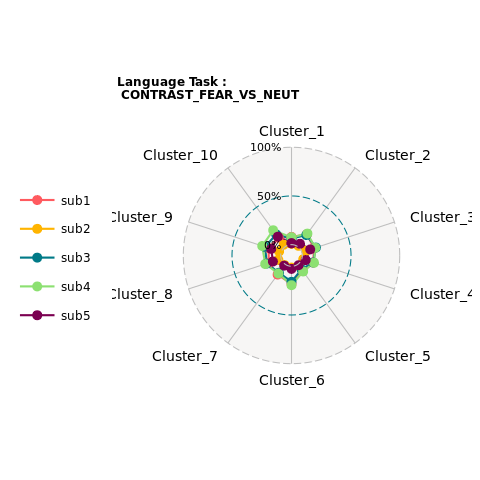

In [23]:
%%R -i path_subtype,path_association,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

# R_squared radar map Machine learning

In [24]:
dict_clusters = json.load(open(os.path.join(path_root,'pheno/hcp_bootstraped_pheno_clusters.txt')))

In [25]:
# import all pheno non clustered data
all_pheno = pd.read_csv(os.path.join(path_root,'pheno/hcp_all_pheno_clean_nonan_norm.csv'))
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'ID'},inplace=True)
all_pheno['ID'] = 'HCP'+ all_pheno['ID'].astype(str)

In [26]:
# collect weight data
dict_tmp = {}
dict_tmp_json = {}
high_r2_dict= dict()
for ind_t, trial_name in enumerate(list_trial) :
    # collect all pheno data
    all_pheno_clust = []
    names_pheno = []
    for ix, pheno_name in enumerate(list_pheno):
        #from IPython.core.debugger import Tracer; Tracer()() 
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_x_norm = mat_load['model_norm']['x']
        model_labels_y_norm = mat_load['model_norm']['labels_y']
        model_labels_x_norm = mat_load['model_norm']['labels_x']
        
        my_pheno = np.array(model_x_norm[:,1])
        my_pheno_name= model_labels_y_norm[1]
        all_pheno_clust.append(my_pheno)
        names_pheno.append(my_pheno_name)
        
    # create pheno dataframe
    all_pheno_clust = np.concatenate([model_labels_x_norm[...,None],np.transpose(all_pheno_clust)],axis=1)
    all_pheno_clust_df = pd.DataFrame(all_pheno_clust,columns=np.append('ID',  list_pheno))
    all_pheno_clust_df['ID'] = all_pheno_clust_df.ID.str.strip()
    
    #collect weight and create dataframe
    weight_file = os.path.join(path_networks,'{}/sbt_weights_net_{}.csv'.format(trial_name,trial_name))
    weight_df = pd.read_csv(weight_file)
    column_names =np.append('ID',  list_subtype)
    weight_df.columns= column_names
    weight_df['ID'] = weight_df.ID.str.strip()
    
    # merge weight amd pheno dataframe
    weight_pheno_clust_df=pd.merge(weight_df,all_pheno_clust_df,on='ID',how='left')
    # save it csv
    weight_pheno_clust_df.to_csv(os.path.join(path_subtype,'{}_weight_pheno_subtype.csv'.format(trial_name)))
    
    # stack to dictionary
    dict_tmp[task_name + "_" + trial_name] = weight_pheno_clust_df
    # stack to json to be saved later
    dict_tmp_json[task_name + "_" + trial_name + "_" + str(nb_sbt) + '_subtypes'] = weight_pheno_clust_df.to_json(orient='split')
    # Merge all pheno with subtype weights
    all_pheno_pruned = pd.merge(weight_pheno_clust_df[['ID']+list_subtype],all_pheno,on='ID',how='left')
    # Drop NaN
    all_pheno_pruned.dropna(inplace=True)
    
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        #from IPython.core.debugger import Tracer; Tracer()() 
        # Set data X Y weight_pheno_clust_df
        X = weight_pheno_clust_df[[pheno_name]]
        x = X.values
        Rsquared_c = np.zeros((np.shape(list_subtype)))
        for iix, subtype_name in enumerate(list_subtype):
            y = weight_pheno_clust_df[subtype_name]
            y = y.values
            Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
            Rsquared_c[iix] = Rsquared.mean()
        if ix == 0:
            pheno_clust_r2_final = pd.Series(Rsquared_c.tolist())
        else:
            pheno_clust_r2_final =pd.concat([pheno_clust_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
    
    # set R2 table        
    pheno_clust_r2_final.columns = list_pheno
    pheno_clust_r2_final.index = list_subtype
    pheno_clust_r2_final = pd.DataFrame(pheno_clust_r2_final)
    pheno_clust_r2_final.to_csv(os.path.join(path_subtype,'{}_r2_SVR.csv'.format(trial_name)))
    
    
    #look for the highest R2 and store feature importance
    arr = pheno_clust_r2_final.values
    index_names = pheno_clust_r2_final.index
    col_names = pheno_clust_r2_final.columns
    #  Get indices where such threshold is crossed; avoid diagonal elems
    R,C = np.where(np.triu(arr,1)>0.05)
    high_r2 = [[index_names[ind_r],col_names[ind_c]] for ind_r,ind_c in zip(R,C)]
    high_r2_dict[trial_name]= high_r2

In [27]:
# # Create estimated R-squared table to be used in R
# high_r2_dict= dict()
# for trial_name in list_trial :
#     # build R2 table for radar plot
#     for ix, pheno_name in enumerate(list_pheno):
#         #from IPython.core.debugger import Tracer; Tracer()() 
#         # Set data X Y weight_pheno_clust_df
#         X = weight_pheno_clust_df[[pheno_name]]
#         x = X.values
#         Rsquared_c = np.zeros((np.shape(list_subtype)))
#         for iix, subtype_name in enumerate(list_subtype):
#             y = weight_pheno_clust_df[subtype_name]
#             y = y.values
#             Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
#             Rsquared_c[iix] = Rsquared.mean()
#         if ix == 0:
#             pheno_clust_r2_final = pd.Series(Rsquared_c.tolist())
#         else:
#             pheno_clust_r2_final =pd.concat([pheno_clust_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
    
#     # set R2 table        
#     pheno_clust_r2_final.columns = list_pheno
#     pheno_clust_r2_final.index = list_subtype
#     pheno_clust_r2_final = pd.DataFrame(pheno_clust_r2_final)
#     pheno_clust_r2_final.to_csv(os.path.join(path_subtype,'{}_r2_SVR.csv'.format(trial_name)))
    
    
#     #look for the highest R2 and store feature importance
#     arr = pheno_clust_r2_final.values
#     index_names = pheno_clust_r2_final.index
#     col_names = pheno_clust_r2_final.columns
#     #  Get indices where such threshold is crossed; avoid diagonal elems
#     R,C = np.where(np.triu(arr,1)>0.05)
#     high_r2 = [[index_names[ind_r],col_names[ind_c]] for ind_r,ind_c in zip(R,C)]
#     high_r2_dict[trial_name]= high_r2

In [28]:
high_r2_dict

{'contrast_fear_vs_neut': []}

In [29]:
path_subtype

'/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/subtype_5_spm_EMOTION_18-Oct-2017/'

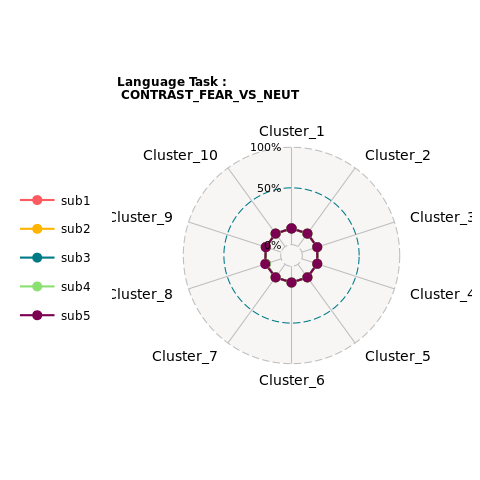

In [30]:
%%R -i path_subtype,path_association,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2_SVR.csv",sep = ''))
    MyData[MyData < 0] <- 0 # put zero for negative R squared
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = -0.02,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_SVR_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

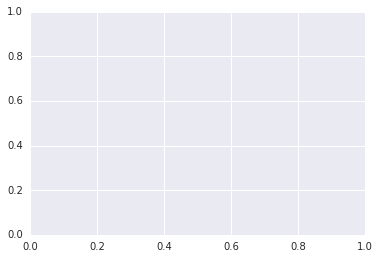

In [31]:
# Plot and save feature importance
fig, axs = plt.subplots()
from IPython.display import display
for hh in range(np.shape(high_r2)[0]):
    X = all_pheno_pruned[dict_clusters[high_r2[:][hh][1]]]
    x = X.values
    Rsquared_c = np.zeros((np.shape(list_subtype)))
    y = weight_pheno_clust_df[high_r2[:][hh][0]]
    y = y.values
    print(high_r2[:][hh])
    Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
    Rsquared_c[iix] = Rsquared.mean()
    
    
    # Threshold future importance
    feimp_thresh =0 # Percentile of future to be removed
    mean_feimp = np.mean(feimp, axis=0)
    mean_std = np.mean(std, axis=0)
    feature_importances = pd.Series(mean_feimp,index= X.columns)
    feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
    std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
    indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]
    
    # Plot Future importance
    axs.set_ylabel('Feature importance - {} '.format(high_r2[:][hh][0]))
    feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],
                                             figsize=(15,6),
                                             title='{}'.format(high_r2[:][hh][1]),
                                             ax=axs)
    #fig.subplots_adjust(top=0.88)
    fig.savefig(os.path.join(path_subtype,'fig_FeatImp_{}-{}.svg'.format(high_r2[:][hh][1],high_r2[:][hh][0])))
    display(fig)

In [198]:
# for trial_name in list_trial :
#     # collect all clusters
#     allClusters = []
#     nameClusters = []
#     for ix, pheno_name in enumerate(list_pheno):
#         #from IPython.core.debugger import Tracer; Tracer()() 
#         mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
#         %octave_push mat_file
#         %octave mat_load = load(mat_file);
#         %octave_pull mat_load
#         model_x_norm = mat_load['model_norm']['x']
#         model_labels_y_norm = mat_load['model_norm']['labels_y']
#         myCluster = np.array(model_x_norm[:,1])
#         myClusterName= model_labels_y_norm[1]
#         allClusters.append(myCluster)
#         nameClusters.append(myClusterName)
        
#     # create clusters
#     allClusters = np.transpose(allClusters)
#     model_y_norm =mat_load['model_norm']['y']
#     model_labels_x_norm = mat_load['model_norm']['labels_x']
    
#     # concatenate clusters with subtype weight
#     concat = [np.concatenate([model_y_norm[x], allClusters[x]]) for x in range(np.shape(model_y_norm)[0])]
#     all_clusters_df = pd.DataFrame(concat)
#     all_clusters_df.index = model_labels_x_norm
#     colnames = np.concatenate([list_subtype,nameClusters])
#     all_clusters_df.columns = colnames
    
#     # save as dataframe
#     all_clusters_df.to_csv(os.path.join(path_subtype,'{}_pheno_subtype.csv'.format(trial_name)))

In [225]:
# # Create estimated R-squared from table to be used in R
# dict_clusters = json.load(open(os.path.join(path_root,'pheno/hcp_bootstraped_pheno_clusters.txt')))
# for trial_name in list_trial :
#     # build R2 table for radar plot
#     for ix, pheno_name in enumerate(list_pheno):
#         #from IPython.core.debugger import Tracer; Tracer()() 
#         # Set data X Y
#         X = all_pheno_pruned[dict_clusters[pheno_name]]
#         x = X.values
#         Rsquared_c = np.zeros((np.shape(list_subtype)))
#         for iix, subtype_name in enumerate(list_subtype):
#             y = all_pheno_pruned[subtype_name]
#             y = y.values
#             Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
#             Rsquared_c[iix] = Rsquared.mean()
#         if ix == 0:
#             pheno_r2_final = pd.Series(Rsquared_c.tolist())
#         else:
#             pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
#     # set R2 table        
#     pheno_r2_final.columns = list_pheno
#     pheno_r2_final.index = list_subtype
#     pheno_r2_final = pd.DataFrame(pheno_r2_final)
#     pheno_r2_final.to_csv(os.path.join(path_subtype,'{}_pheno_r2_SVR.csv'.format(trial_name)))

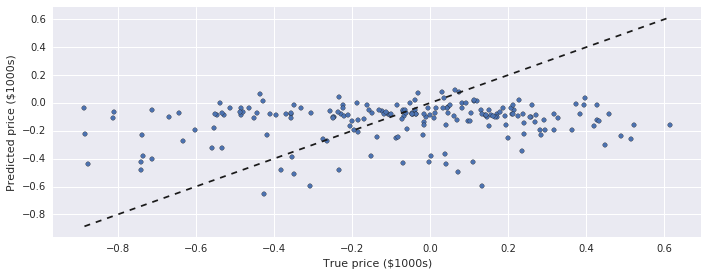

In [202]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y)

clf = GradientBoostingRegressor( max_depth=6, learning_rate=0.04,
                                loss='huber', random_state=0)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)
expected = y_test

plt.figure(figsize=(10, 4))
plt.scatter(expected, predicted)
plt.plot([expected.min(),expected.max()], [expected.min(),expected.max()],'--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')
plt.tight_layout()